In [1]:
import sys
import pandas as pd
import Quandl
import json

sys.path.append('..')
from Data.StockDataManager import *
from Data.TimeSeries import *
settings = Settings()


## ETF tickers

In [ ]:
tickers = ['GOOG/NYSE_SPY', #S&P 500 ETF 
           'GOOG/AMEX_EWJ', # iShares MSCI Japan ETF
           'GOOG/NYSE_IEV', # iShares Europe ETF
           'GOOG/NYSE_VWO', # Vanguard Emerging Market Stock ETF
           
           #'GOOG/NYSE_VNQ', # Vanguard MSCI US Reits
           'GOOG/NYSE_IYR', # iShares U.S. Real Estate ETF
           'GOOG/NYSE_RWX', # SPDR DJ Wilshire Intl Real Estate ETF
           
           'GOOG/NYSEARCA_TLT',  # 20 Years Treasury ETF
           'GOOG/NYSEARCA_TLH',  # 15-20 Years Treasury
           
           'GOOG/AMEX_GSG', # GSCI Commodity-Indexed Trust Fund
           'GOOG/NYSEARCA_GLD',  # SPDR Gold ETF
           ]

micai_tickers = ['GOOG/NYSE_VWO', 
                'GOOG/NYSE_VPL', 
                'GOOG/NYSE_VGK', 
                'GOOG/NYSE_VTI',
                'GOOG/NYSE_BND', #美国债券ETF
                'GOOG/AMEX_BWX', #SPDR Barclays Intl Treasury bond etf
                'GOOG/NYSEARCA_LQD', #iShares IBoXX & Invest Grade Corp Bond 
                'GOOG/NYSEARCA_EMB' #iShares JPMorgan Emerging Mkt Bond
                 ]

sector_tickers = ['GOOG/NYSEARCA_XLB',
           'GOOG/NYSEARCA_XLE', 
           'GOOG/NYSEARCA_XLF',
           'GOOG/NYSEARCA_XLI',
           'GOOG/NYSEARCA_XLK',
           'GOOG/NYSEARCA_XLP', 
           'GOOG/NYSEARCA_XLU', 
           'GOOG/NYSEARCA_XLV', 
           'GOOG/NYSEARCA_XLY']


TimeSeries(settings).store_ETF_data(micai_tickers)
TimeSeries(settings).store_ETF_data(tickers)
TimeSeries(settings).store_ETF_data(sector_tickers)

In [ ]:
import matplotlib 
%matplotlib inline
from Data.TimeSeries import TimeSeries
from Data.StockDataManager import Settings
ts = TimeSeries(Settings())
df_prices = ts.get_agg_data(micai_tickers)

In [ ]:
df_prices[:,:,'price'].dropna().plot(figsize=[20,10])

## SPY Stocks 

In [ ]:
df_tickers = pd.read_csv('./SP500.csv')
spy_tickers = df_tickers['free_code']

In [ ]:
df_tickers[130::]

In [ ]:
def store_Stock_data(tickers):
    settings = Settings()
    db = settings.get_mongo_db(local=True)
    coll = db['Stock']

    for t in tickers:

        # find the ticker
        dates = coll.find_one({'name':t}, sort=[('Date', -1)])
        if (dates is None):
            print 'max_date is none'
            mdate = None
        else :
            mdate = pd.to_datetime(dates['Date']*1000*1000).strftime(format='%Y-%m-%d')
            
        print 'downloadng {t}'.format(t=t)


        df = Quandl.get(t, trim_start=mdate, authtoken='AuFngLLqDpLf672K9W85')
        df = df.reset_index()


        if mdate is None :
            df_a = df
        else :
            df_a = df[df['Date'] > mdate]

        if len(df_a) == 0:
            print "data for {ticker} is already updated till {date}".format(ticker=t, date=mdate)
            continue

        df_adj = pd.DataFrame()
        df_adj['Date'] = df_a['Date']
        df_adj['Open'] = df_a['Adj. Open']
        df_adj['High'] = df_a['Adj. High']
        df_adj['Low'] = df_a['Adj. Low']
        df_adj['Close'] = df_a['Adj. Close']
        df_adj['Volume'] = df_a['Adj. Volume']
        df_adj['name'] = t  

        records = json.loads(df_adj.T.to_json()).values()
        # #print records
        print "uploading {t}".format(t=t)
        coll.insert_many(records)

In [ ]:
store_Stock_data(spy_tickers[154::])

## Fred St.Louis Data

In [ ]:
df_fred = pd.read_csv('fred_index.csv')
fred_tickers = df_fred['free_code']
fred_tickers

In [ ]:
# store_fre_data(fred_tickers)
df_fred = ts.get_agg_Fred_data(fred_tickers)

## Smart Beta ETF


In [62]:
smartbeta_tickers = [ 
                    'GOOG/NYSEARCA_QUAL', # Quality Factor
                    'GOOG/NYSEARCA_VLUE', # value Factor
                    'GOOG/NYSEARCA_SIZE', # Size Factor
                    'GOOG/NYSEARCA_MTUM', # Momentum Factors 
#                     'GOOG/NYSE_SPY'
                ]
ticker_spy = 'GOOG/NYSE_SPY'

#smartbeta_tickers + ['GOOG/NYSE_SPY']
#TimeSeries(Settings()).store_ETF_data(smartbeta_tickers)

downloadng GOOG/NYSEARCA_QUAL
data for GOOG/NYSEARCA_QUAL is already updated till 2016-03-22
downloadng GOOG/NYSEARCA_VLUE
data for GOOG/NYSEARCA_VLUE is already updated till 2016-03-23
downloadng GOOG/NYSEARCA_SIZE
data for GOOG/NYSEARCA_SIZE is already updated till 2016-03-22
downloadng GOOG/NYSEARCA_MTUM
data for GOOG/NYSEARCA_MTUM is already updated till 2016-03-22


In [19]:
import matplotlib 
%matplotlib inline
from Data.TimeSeries import TimeSeries
from Data.StockDataManager import Settings
ts = TimeSeries(Settings())
dp = ts.get_agg_ETF_data(smartbeta_tickers)

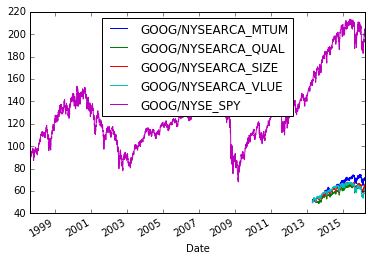

In [31]:
dp = dp.fillna(method='pad')
# df_prices = df_prices.dropna()
dp[:,:,'price'].plot()

In [27]:
df_prices = dp[:, :,'price'].dropna()
df_ret = df_prices.pct_change()
df_ret_spy = df_ret['GOOG/NYSE_SPY']

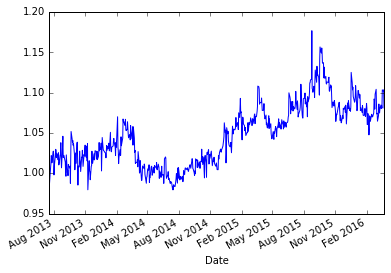

In [56]:
(1+df_ret.sum(axis=1) - 5*df_ret_spy).cumprod().plot()

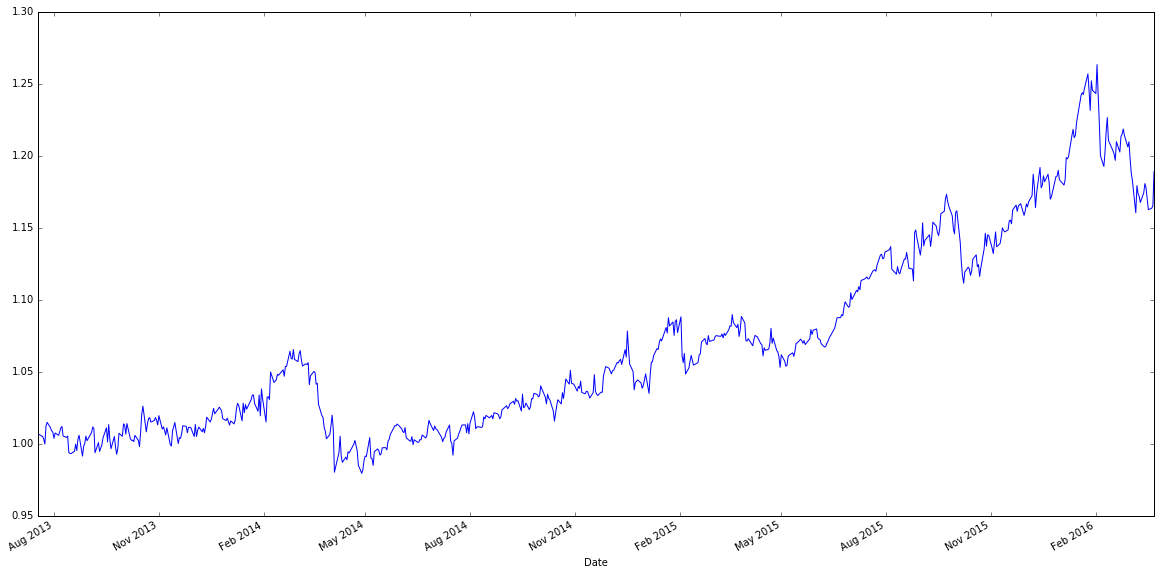

In [60]:
(1+df_ret.iloc[:, 0] - df_ret.iloc[:, 3]).cumprod().plot(figsize=[20,10])

In [95]:
df_spy = df_prices[[ticker_spy]]
df_spy['ma'] = pd.rolling_mean(df_prices[ticker_spy], 60)
df_spy = df_spy.dropna()
df_spy['sig'] = (df_prices[ticker_spy] > pd.rolling_mean(df_prices[ticker_spy], 200))*1
df_spy['ret'] = df_spy[ticker_spy].pct_change()
df_spy['ret_1'] = (df_ret[smartbeta_tickers[0]] - df_ret[ticker_spy]) * df_spy['sig'].shift(1)
df_spy['ret_2'] = ( df_ret[ticker_spy] - df_ret[smartbeta_tickers[1]])* (1-df_spy['sig']).shift(1)
df_spy['ret_s'] = df_spy['ret_1'] + df_spy['ret_2']

/Users/jianboxue/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


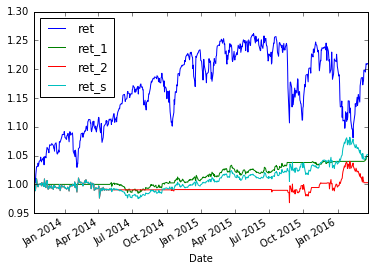

In [96]:
(1+df_spy[['ret', 'ret_1', 'ret_2', 'ret_s']]).cumprod().plot()

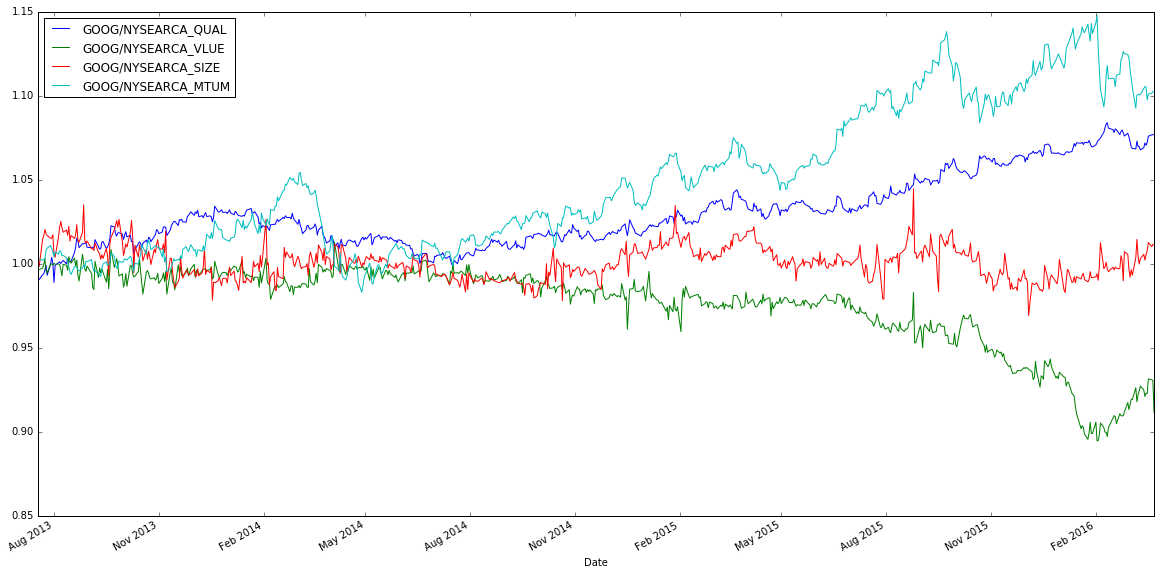

In [97]:
df_delta = pd.DataFrame()
for i in smartbeta_tickers:
    df_delta[i] = df_ret[i] - df_ret_spy
    
(1+df_delta).cumprod().plot(figsize=[20,10])